# Traffic Sign Classification

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

## Defining Functions and Classes

Functions and Classes for:
- Loading
- Analizing distribution over labels
- Network Architecture
- Calculating train loss, val loss and val accuracy
- Training and plotting results
- Testing and plotting results

### Data Loaders


In [2]:
def create_data_loaders(path_train, path_test, path_test_labels, batch_size, validation_ratio=0.9):
    """Create data loaders for the training and validation set.

    Args:
        path_train (str): Path to the training set.
        path_test (str): Path to the test set.
        path_test_labels (str): Path to the test labels.
        batch_size (int): Batch size.
        validation_ratio (float): Ratio of the training set to use for validation.

    Returns:
        train_loader (DataLoader): Training set data loader.
        val_loader (DataLoader): Validation set data loader
        test_loader (DataLoader): Validation set data loader.
        test_labels (tensor): tensor with labels for the test set.
    """

    data_transforms = transforms.Compose([
        transforms.Resize([112, 112]),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))])
        
    train_data = ImageFolder(root = path_train, transform = data_transforms)
    test_data = ImageFolder(root = path_test, transform = data_transforms)

    n_train_examples = int(len(train_data) * validation_ratio)
    n_val_examples = len(train_data) - n_train_examples

    train_data, val_data = random_split(train_data, [n_train_examples, n_val_examples])

    train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
    val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size = batch_size)

    test_data = pd.read_csv(path_test_labels, sep=';')
    test_labels = torch.tensor(test_data['ClassId'].values)

    return train_loader, val_loader, test_loader, test_labels

### Analizing distribution over labels

In [3]:
def plot_data_distribution(loader):
    """
    Plot the distribution of class labels in a data loader.

    Args:
        loader (torch.utils.data.DataLoader): The data loader for which the distribution should be plotted.
    """

    # Initialize a tensor to count the number of labels per class
    total_labels = torch.zeros(43)

    # Loop over batches in the data loader
    for (images, labels) in loader:
        for label in labels:
            # Increment the count for the current label
            total_labels[label] += 1

    # Create a bar plot to visualize the distribution of labels
    plt.bar(range(43), total_labels)
    plt.show()

### Network Design


In [4]:
class ResBlock(nn.Module):
    """
    Residual block implementation for a neural network.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initialize the ResBlock with the given input and output channels.
        
        :param in_channels: Number of input channels.
        :param out_channels: Number of output channels.
        """
        super().__init__()

        if in_channels == out_channels:
            self.identity = True
            self.net = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding='same'),
                                     nn.BatchNorm2d(out_channels),
                                     nn.ReLU(),
                                     nn.Conv2d(out_channels, out_channels, 3, padding='same'),
                                     nn.BatchNorm2d(out_channels),
                                     nn.ReLU(inplace=True))

        else:
            self.identity = False

            self.net = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                                     nn.BatchNorm2d(out_channels),
                                     nn.ReLU(),
                                     nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
                                     nn.BatchNorm2d(out_channels),
                                     nn.ReLU())

            self.W = nn.Conv2d(in_channels, out_channels, 1, stride=2)

    def forward(self, x):
        """
        Forward pass for the residual block.
        
        :param x: Input tensor.
        :return: Output tensor after applying the residual block.
        """
        if self.identity:
            return self.net(x) + x
        else:
            return self.net(x) + self.W(x)


class Network(nn.Module):
    """
    Network class implementing the main neural network architecture.
    """

    def __init__(self) -> None:
        """
        Initialize the Network.
        """
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(3, 32, 3, 2, padding=1),
                                 nn.BatchNorm2d(32),
                                 nn.ReLU(),
                                 ResBlock(32, 32),
                                 ResBlock(32, 44),
                                 ResBlock(44, 44),
                                 ResBlock(44, 88),
                                 ResBlock(88, 176),
                                 ResBlock(176, 176),
                                 nn.AvgPool2d(2),
                                 nn.Flatten(),
                                 nn.Linear(1584, 43),
                                 nn.Softmax(dim=1))

    def forward(self, x):
        """
        Forward pass for the network.
        
        :param x: Input tensor.
        :return: Output tensor (logits) after applying the network.
        """
        logits = self.net(x)
        return logits

    def calculate_loss(self, logits, y):
        """
        Calculate the cross-entropy loss.
        
        :param logits: Predicted logits from the network.
        :param y: Ground truth labels.
        :return: Cross-entropy loss.
        """
        return F.cross_entropy(logits, y)

    def save_model(self, path):
        """
        Save the model state to a file.
        
        :param path: Path to save the model state.
        """
        torch.save(self.state_dict(), path)

    def accuracy(self, out, labels):
        """
        Calculate the accuracy of the network predictions.
        
        :param out: Output tensor from the network.
        :param labels: Ground truth labels.
        :return: Accuracy .
        """
        _, preds = torch.max(out, dim=1)
        return torch.sum(preds == labels).item() / len(preds)
    
    def load_model(self, path_to_file):

        self.load_state_dict(torch.load('path_to_file'))

    

In [5]:
n = Network()
t = torch.rand((1,3,112,112))

n(t).shape

torch.Size([1, 43])

### Calculating train loss, val loss, and val accuracy

In [5]:
import torch

# Disable gradient calculation for this function
@torch.no_grad()
def train_val_loss(model_, num_batches, train_loader, val_loader, device):
    """
    Compute the average training and validation loss for a given model and data loaders.

    Args:
        model_ (torch.nn.Module): The model to evaluate.
        num_batches (int): The number of batches to use for the evaluation.
        train_loader (torch.utils.data.DataLoader): The data loader for the training set.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation set.
        device (torch.device): The device to perform the computations on.

    Returns:
        out (dict): A dictionary containing the average loss for both training and validation sets.
        acc_mean (float): The mean accuracy for the validation set.
    """

    # Initialize the output dictionary and accuracy tensor
    out = {}
    acc = torch.zeros(num_batches)

    # Set the model to evaluation mode
    model_.eval()

    # Loop over both data loaders (train and validation)
    for loader, split in zip([train_loader, val_loader], ['train', 'val']):

        # Initialize the losses tensor
        losses = torch.zeros(num_batches)

        # Initialize the batch index
        i = 0

        # Loop over batches in the data loader
        for (images, labels) in loader:

            # Compute the logits from the model
            logits = model_(images.to(device))

            # Move the labels to the device
            lab = labels.to(device)

            # Calculate the loss for the current batch
            loss = model_.calculate_loss(logits, lab)

            # Store the loss
            losses[i] = loss.item()

            # Calculate and store the accuracy for the validation set
            if split == 'val':
                acc[i] = model_.accuracy(logits, lab)

            # Break the loop if we reached the specified number of batches
            if i == num_batches - 1:
                break

            # Increment the batch index
            i += 1

        # Store the mean loss for the current split
        out[split] = losses.mean()

    # Set the model back to training mode
    model_.train()

    # Return the output dictionary and mean accuracy
    return out, acc.mean()

### Training procedure

In [6]:
def training_network(model, train_loader, val_loader, optimizer, epochs, device):
    """
    Train the neural network model using provided data loaders and optimizer.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): The data loader for the training set.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation set.
        optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
        epochs (int): The number of epochs to train the model.
        device (torch.device): The device to perform the computations on.

    Returns:
        train_losses (List)
        val_losses (List)
        val_accuracies (List)
    """

    train_losses, val_losses, val_accuracies = [],[],[]

    # Set the model to training mode
    model.train()

    # Loop over the specified number of epochs
    for epoch in range(epochs):

        # Evaluate the model and print the losses and accuracy at the specified interval
        losses, acc = train_val_loss(model, 10, train_loader, val_loader, device)
        print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val accuracy {acc:.4f}")

        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        val_accuracies.append(acc)

        # Loop over batches in the training data loader
        for (images, labels) in train_loader:

            # Move the images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # Training pass
            optimizer.zero_grad()

            output = model(images)

            loss = model.calculate_loss(output, labels)

            # Backpropagation
            loss.backward()

            # Optimizing weights
            optimizer.step()

    return train_losses, val_losses, val_accuracies


def plot_train_results(train_losses, val_losses, val_accuracies):
    """
    Plot the training losses, validation losses, and validation accuracies over time.

    Args:
        train_losses (torch.Tensor or list): A tensor or list containing the training losses.
        val_losses (torch.Tensor or list): A tensor or list containing the validation losses.
        val_accuracies (torch.Tensor or list): A tensor or list containing the validation accuracies.
    """

    # Create a tensor with the range of indices based on the length of train_losses
    x = torch.arange(len(train_losses))

    # Create a figure with specified dimensions
    fig = plt.figure(figsize=(24, 10))

    # Add a subplot for plotting training and validation losses
    fig.add_subplot(1, 2, 1)

    # Plot the training and validation losses
    plt.plot(x, train_losses, label='Train Loss')
    plt.plot(x, val_losses, label='Val Loss')

    # Add legend and labels for the first subplot
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Add a subplot for plotting validation accuracies
    fig.add_subplot(1, 2, 2)

    # Plot the validation accuracies
    plt.plot(x, val_accuracies, label='Val Accuracy')

    # Add legend and labels for the second subplot
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')

    # Display the plot
    plt.show()


### Test performance: accuracy and confusion matrix

In [7]:
@torch.no_grad()
def test(model_, test_loader, ground_truth, device, batch_size):
    """
    Evaluate the model on a test set and compute the confusion matrix.

    Args:
        model_ (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): The data loader for the test set.
        ground_truth (torch.Tensor): The ground truth labels for the test set.
        device (torch.device): The device to perform the computations on.
        batch_size (int): The batch size used in the data loader.

    Returns:
        acc_mean (float): The mean accuracy on the test set.
        conf_matrix (torch.Tensor): The normalized confusion matrix.
    """

    # Move the model to the device
    model_.to(device)

    # Initialize the confusion matrix
    conf_matrix = torch.zeros((43, 43))

    # Initialize the accuracy and batch index
    acc = 0
    l = 0

    # Loop over batches in the test data loader
    for (images, labels) in test_loader:

        # Compute the model output
        out = model_(images.to(device))

        # Get the predicted class labels
        _, preds = torch.max(out, dim=1)

        # Update the confusion matrix
        for i in range(len(preds)):
            conf_matrix[ground_truth[l*batch_size + i].item(), preds[i]] += 1

        # Calculate and accumulate the accuracy
        acc += model_.accuracy(out, ground_truth[images.shape[0]*l:images.shape[0]*l+images.shape[0]].to(device))
        l += 1

    # Normalize the confusion matrix by the number of samples per class
    for i in range(43):
        conf_matrix[i, :] = conf_matrix[i, :] / ground_truth[ground_truth == i].shape[0]

    # Calculate the mean accuracy
    acc_mean = acc / l

    return acc_mean, conf_matrix


def plot_test_results(conf_matrix, accuracy):
    """
    Plot the confusion matrix and print the accuracy for a test set.

    Args:
        conf_matrix (torch.Tensor): The confusion matrix for the test set.
        accuracy (float): The mean accuracy on the test set.
    """

    # Print the mean accuracy
    print('ACCURACY:', accuracy)
    print('------------------------')
    print('CONFUSION MATRIX:')

    # Create a figure with specified dimensions
    plt.figure(figsize=(14, 14))

    # Display the confusion matrix as an image with a blue colormap
    plt.imshow(conf_matrix, cmap='Blues')

    # Add text labels to each cell in the confusion matrix
    for i in range(43):
        for j in range(43):
            plt.text(j, i, f"{conf_matrix[i, j]*100:.0f}", ha="center", va="center", color="r")

    # Set the labels for the x and y axes
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Display the plot
    plt.show()

## Experiment 1: Training without data augmentation with the following parameters:

- Batch size = 400
- Validation size = 0.1
- Learning rate = 0.001
- Optimizer algorithm: Adam
- Evaluation every 100 batches
- Epochs = 45

In [8]:

# Set the batch size
batch_size = 400

# Create data loaders for the train, validation, and test sets
train_loader, val_loader, test_loader, test_labels = create_data_loaders('Final_Training/Images', 'Final_Test','GT-final_test.csv', batch_size, 0.9)

# Choose the appropriate device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
model = Network().to(device)

# Set the learning rate
lr = 0.001

# Create an optimizer for updating model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set the number of epochs for training
epochs = 40

### Training distribution

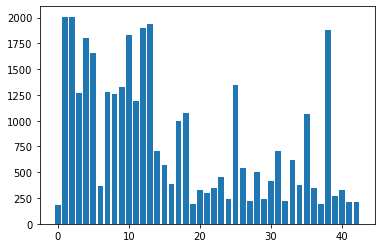

In [10]:
plot_data_distribution(train_loader)

### Experiment 1 - Training

In [11]:
train_losses, val_losses, val_accuracies = training_network(model, train_loader, val_loader, optimizer, epochs, device)

model.save_model('model_exp_1.pt')

epoch 0: train loss 3.7613, val loss 3.7613, val accuracy 0.0191
epoch 1: train loss 3.4415, val loss 3.4498, val accuracy 0.3546
epoch 2: train loss 3.3094, val loss 3.3132, val accuracy 0.4885
epoch 3: train loss 3.0865, val loss 3.0882, val accuracy 0.7160
epoch 4: train loss 3.0191, val loss 3.0202, val accuracy 0.7814
epoch 5: train loss 3.0180, val loss 3.0162, val accuracy 0.7866
epoch 6: train loss 3.0053, val loss 3.0073, val accuracy 0.7926
epoch 7: train loss 2.9434, val loss 2.9492, val accuracy 0.8542
epoch 8: train loss 2.9242, val loss 2.9275, val accuracy 0.8737
epoch 9: train loss 2.9035, val loss 2.9115, val accuracy 0.8892
epoch 10: train loss 2.8755, val loss 2.8844, val accuracy 0.9190
epoch 11: train loss 2.8516, val loss 2.8595, val accuracy 0.9411
epoch 12: train loss 2.8509, val loss 2.8581, val accuracy 0.9428
epoch 13: train loss 2.8426, val loss 2.8493, val accuracy 0.9525
epoch 14: train loss 2.8496, val loss 2.8482, val accuracy 0.9526
epoch 15: train loss

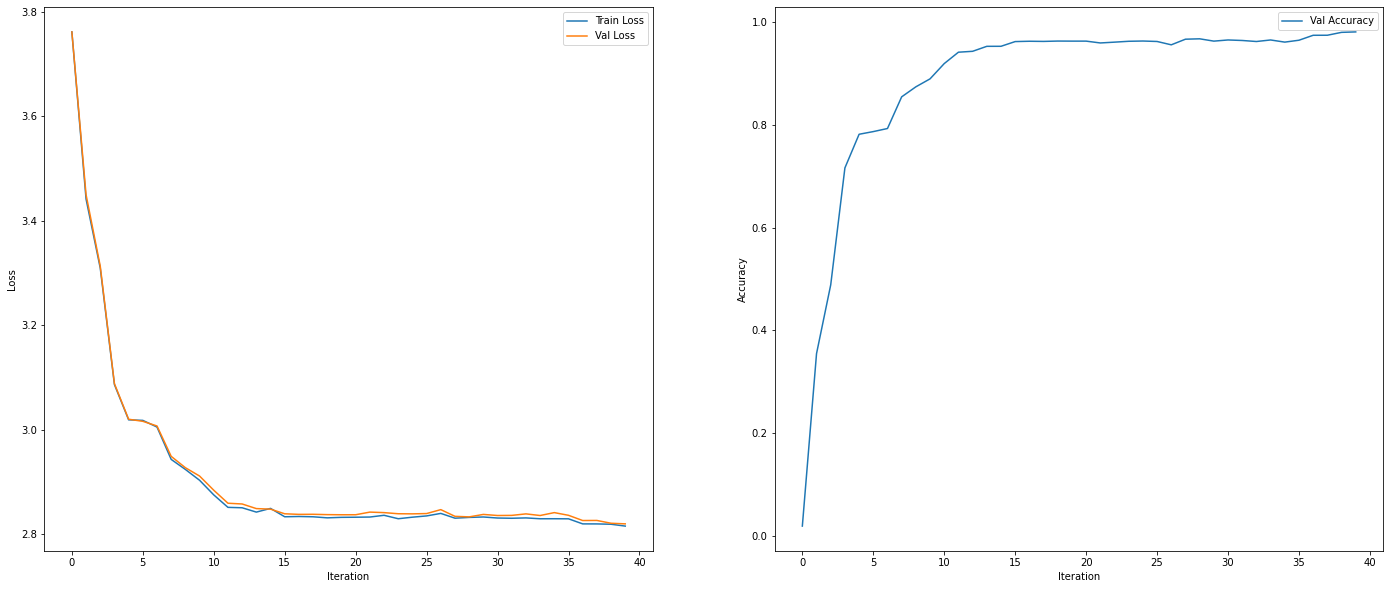

In [12]:
#Uncomment to load pretrained model

#model = Network().to(device)
#model.load_model('model_exp_1.pt')

plot_train_results(train_losses, val_losses, val_accuracies)

### Performance in test set

ACCURACY: 0.9298165760869566
------------------------
CONFUSION MATRIX:


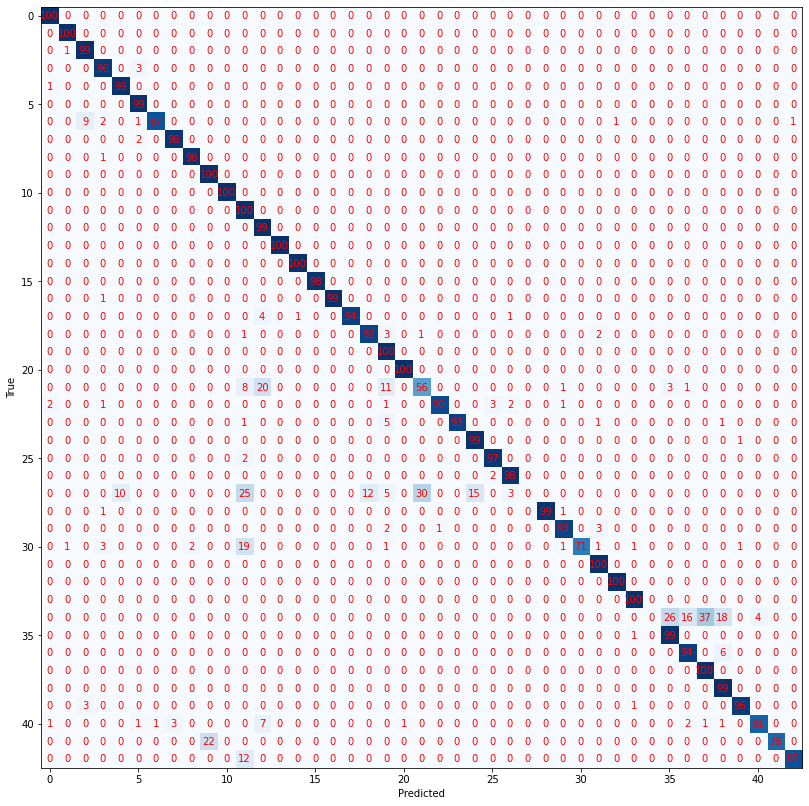

In [13]:
acc, conf_matrix = test(model, test_loader, test_labels, device, batch_size)
plot_test_results(conf_matrix, acc)

## Experiment 2: training with data augmentation

### Augment function

The following function takes the path to the training data as input and for each folder it augments the number of samples if the number of samples are less than the cutoff. To augment the data it selects randomly an image an apply randomly one of two transforms: Gaussian Blur or Color Jitter. It repeats this process until the number of samples is close or equal to the cutoff.

In [9]:
def augment_data_set(path_data_to_aug, cutoff):
    """
    Augment the dataset by applying random transformations to images in classes with fewer samples than the cutoff.

    Args:
        path_data_to_aug (str): The path to the dataset to augment.
        cutoff (int): The minimum number of samples per class.
    """

    # Define image transformation functions
    convert_tensor = transforms.ToTensor()
    convert_to_image = transforms.ToPILImage()
    change_color = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5) # type: ignore
    blur = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

    # List of possible transformations
    possible_transforms = [change_color, blur]

    # Loop over each class folder (0-42)
    for i in range(43):

        # Generate folder names with appropriate leading zeros
        str_zeros = '0000' if i < 10 else '000'
        path = os.path.join(path_data_to_aug, str_zeros + str(i))

        # List all files in the folder
        files = os.listdir(path)

        # Count the number of files
        num_files = len(files)

        # Check if the number of files is less than the cutoff
        if num_files < cutoff:

            # Calculate the number of augmented files needed
            num_augmented_files = cutoff - num_files - 1

            # Randomly choose existing files for augmentation
            indexes = torch.randint(0, num_files, (num_augmented_files,))

            # Loop over the chosen files
            for j in range(indexes.shape[0]):

                # Get the file name
                file = files[indexes[j]]

                # Check if the file is an image (.ppm format)
                if file.endswith(".ppm"):
                    # Open the image
                    img = Image.open(os.path.join(path, file))

                    # Convert the image to a tensor
                    img_tensor = convert_tensor(img)

                    # Randomly choose a transformation to apply
                    index = torch.randint(0, len(possible_transforms), (1,)).item()

                    # Apply the transformation to the image tensor
                    img_tensor_transformed = possible_transforms[index](img_tensor) # type: ignore

                    # Convert the transformed tensor back to an image
                    image_transformed = convert_to_image(img_tensor_transformed)

                    # Save the transformed image with a new name
                    image_transformed.save(os.path.join(path, file[:-4] + '_aug' + str(j) + '.ppm'))



### Data augmentation

In [10]:
augment_data_set('Final_Training_Augmented/Images/', 1100)

### Experiment 2: parameters

- Batch size = 400
- Validation size = 0.1
- Learning rate = 0.001
- Optimizer algorithm: Adam
- Evaluation every 100 batches
- Epochs = 15

In [12]:
# Set the batch size
batch_size = 400

# Create data loaders for the train, validation, and test sets
train_loader_1, val_loader_1, test_loader_1, test_labels_1 = create_data_loaders('Final_Training_Augmented/Images/', 'Final_Test', 'GT-final_test.csv', 400, 0.9)

# Choose the appropriate device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
model_1 = Network().to(device)

# Set the learning rate
lr = 0.001

# Create an optimizer for updating model parameters
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)

# Set the number of epochs for training
epochs_1 = 40

### Training distribution

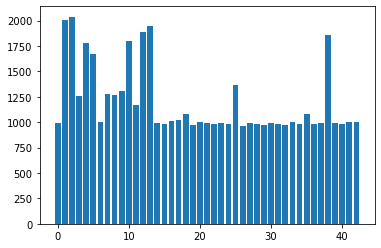

In [13]:
plot_data_distribution(train_loader_1)

### Experiment 2: training

In [14]:
train_losses_1, val_losses_1, val_accuracies_1 = training_network(model_1, train_loader_1, val_loader_1, optimizer_1, epochs_1, device)

model_1.save_model('model_exp_2.pt')

epoch 0: train loss 3.7612, val loss 3.7612, val accuracy 0.0198
epoch 1: train loss 3.4372, val loss 3.4473, val accuracy 0.3548
epoch 2: train loss 3.2604, val loss 3.2641, val accuracy 0.5435
epoch 3: train loss 3.0608, val loss 3.0694, val accuracy 0.7328
epoch 4: train loss 2.9623, val loss 2.9724, val accuracy 0.8292
epoch 5: train loss 2.9170, val loss 2.9211, val accuracy 0.8813
epoch 6: train loss 2.8690, val loss 2.8740, val accuracy 0.9280
epoch 7: train loss 2.8465, val loss 2.8602, val accuracy 0.9422
epoch 8: train loss 2.8409, val loss 2.8580, val accuracy 0.9433
epoch 9: train loss 2.8451, val loss 2.8526, val accuracy 0.9480
epoch 10: train loss 2.8414, val loss 2.8499, val accuracy 0.9508
epoch 11: train loss 2.8211, val loss 2.8270, val accuracy 0.9745
epoch 12: train loss 2.8022, val loss 2.8037, val accuracy 0.9977
epoch 13: train loss 2.8013, val loss 2.8034, val accuracy 0.9980
epoch 14: train loss 2.8005, val loss 2.8012, val accuracy 0.9993
epoch 15: train loss

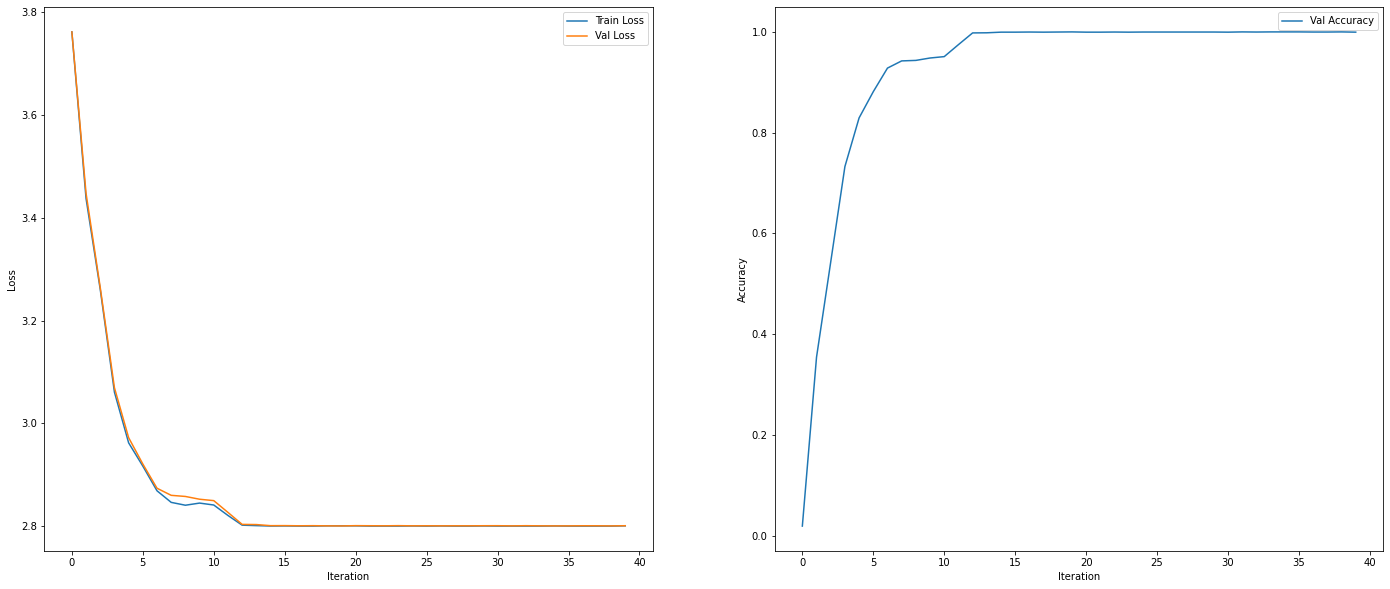

In [15]:
#Uncomment to load pretrained model

#model = Network().to(device)
#model.load_model('model_exp_2.pt')

plot_train_results(train_losses_1, val_losses_1, val_accuracies_1)

### Performance in test set

ACCURACY: 0.9562228260869565
------------------------
CONFUSION MATRIX:


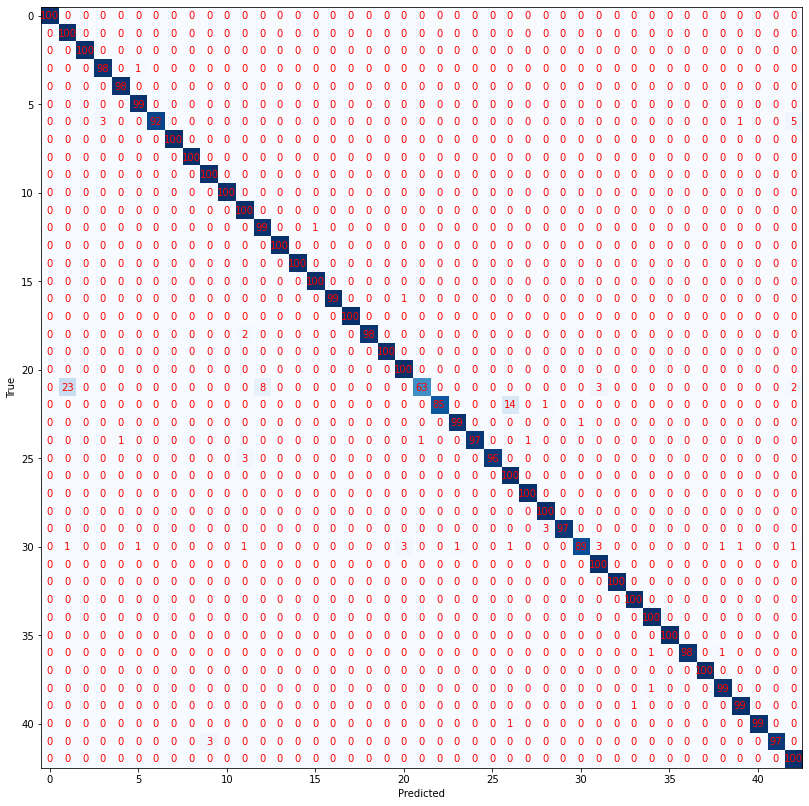

In [16]:
acc_1, conf_matrix_1 = test(model_1, test_loader_1, test_labels_1, device, batch_size)
plot_test_results(conf_matrix_1, acc_1)